### Viviescas Phys. Rev. Lett. 105 2010

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(1,'../../')
import qtrajectories as qtr
from sympy import *

# plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [10,5]

In [2]:
from numba import njit

In [3]:
## Viviescas Phys. Rev. Lett. 105 2010

## main()
qub0 = np.array([0,1], dtype = np.complex128)
qub1 = np.array([1,0], dtype = np.complex128)

#### Parameters 
gamma = 2
t0 = 0
tf = 1
time_steps = 50000

## Time range
t = np.linspace(t0, tf, np.int32(time_steps))

## Initial state 
psi00 = (1/np.sqrt(8))
psi01 = (1/np.sqrt(8))*(-1)
psi10 = (1/np.sqrt(8))*1j
psi11 = (1/np.sqrt(8))*1j*np.sqrt(5)
psi0 = (psi00*np.kron(qub0,qub0) + psi01*np.kron(qub0,qub1) + psi10*np.kron(qub1,qub0) + psi11*np.kron(qub1,qub1))

## Hamiltonian
@njit
def H(t):
    return np.zeros((4,4), dtype = np.complex128)

## Lindblad operators
@njit
def L(t):
    num_op = 2
    L_list = np.zeros((num_op,4,4), dtype=np.complex128)
    L_list[0] = np.sqrt(gamma)*np.kron(qtr.sigmam, np.eye(2, dtype = np.complex128))
    L_list[1] = np.sqrt(gamma)*np.kron(np.eye(2, dtype = np.complex128), qtr.sigmam)
    return L_list

## Concurrence
@njit
def C(psi):
    op = np.kron(qtr.sigmay,qtr.sigmay)
    return np.linalg.norm(np.dot(psi,np.dot(op,psi)))

@njit
def C_rho(rho):
    op = np.kron(qtr.sigmay,qtr.sigmay)
    rho_ = np.dot(op,np.dot(np.conjugate(rho),op))
    rhorho_ = np.dot(rho,rho_)
    lambda_ = np.sqrt(np.abs(-1*np.sort(-1*np.real(np.linalg.eig(rhorho_)[0]))))
    return np.max(np.array([0, np.abs(lambda_[0] - lambda_[1] - lambda_[2] - lambda_[3])]))

@njit
def C_bar(psi):
    op = np.kron(qtr.sigmay,qtr.sigmay)
    return np.dot(psi,np.dot(op,psi))

## Theta opt
theta_opt = np.angle(np.conjugate(C_bar(psi0))*(psi11)**2)

## Unraveling
u_opt = np.array([[0, -1*np.exp(1j*theta_opt)],[-1*np.exp(1j*theta_opt), 0]], dtype = np.complex128)
#o_matrix = 0.5*np.array([[1,1,1,1],[1,1,-1,-1],[1,-1,1,-1],[1,-1,-1,1]])
o_matrix = np.eye(4)

In [4]:
## Class object
qubits = qtr.System(H, psi0, t, lindbladList = L, uMatrix = u_opt, oMatrix = o_matrix)

In [5]:
%%time
diff_traj = qubits.diffusiveRhoTrajectory()

Compiling diffusiveRhoTrajectory ...
CPU times: user 11.6 s, sys: 58.9 ms, total: 11.7 s
Wall time: 11.8 s


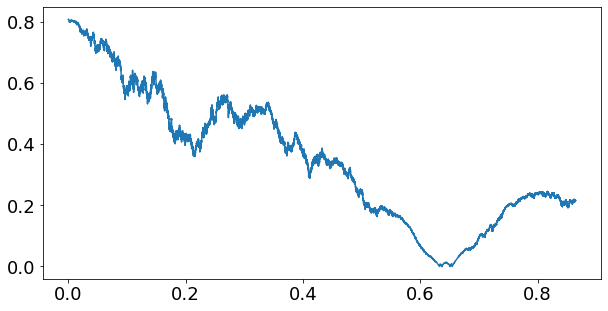

In [6]:
concurrence = []
for traj in diff_traj:
    concurrence.append(C_rho(traj))
    
## Time scaling
p = 1 - np.exp(-gamma*t)

plt.plot(p, concurrence)

In [7]:
%%time
mu = 15
coherent_fields = np.array([mu,mu,mu,mu], dtype=np.complex128)

jump_traj = qubits.jumpRhoTrajectory(coherent_fields=coherent_fields, seed=1)

Compiling jumpRhoTrajectory ...
CPU times: user 10.9 s, sys: 40.9 ms, total: 10.9 s
Wall time: 11.1 s


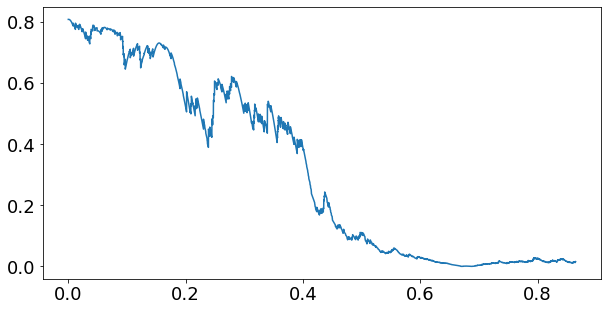

In [8]:
concurrence = []
for traj in jump_traj:
    concurrence.append(C_rho(traj))
    
## Time scaling
p = 1 - np.exp(-gamma*t)

plt.plot(p, concurrence)